In [2]:
# Imports
import pandas as pd
import numpy as np
import os
import seaborn as sns

pd.set_option('display.max_colwidth', 40)

In [3]:
# Load Datasets
list_dfs = []

for _,_, files in os.walk('dataset'):
	for file in files:
		if file.split('.')[-1] == 'csv':
			list_dfs.append(pd.read_csv(f'dataset\{file}'))

len(list_dfs)

14

In [4]:
#Convert and rename datasets
df = pd.concat(list_dfs).reset_index().drop(columns='index')

columns_to_rename = {
    "TAA":"alerts", 
    "TA": "departure_hour_delayed", 
    "TIN":"train_model", 
    "TIR":"route", 
    "TSI":"station_id", 
    "TIM":"direction", 
    "TIL":"request", 
    "TIRE":"destination",
    "TIP":"plattform", 
    "TIT": "departure_hour", 
    "TID":"date", 
    "TSC":"station_and_id", 
    "TAc":"delay_in_minutes"}

df = df.rename(columns=columns_to_rename)

df.head()

,alerts,departure_hour_delayed,train_model,route,station_id,direction,request,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes
0,,NaN,RE 5(28522),Koblenz Hbf 14:17-Koblenz Stadtmitte...,8000044.0,arr,/bin/traininfo.exe/dn/5337/348632/44...,Koblenz Hbf,1,15:02,16.06.19,Bonn%238000044,0
1,,NaN,RB48(32455),Wuppertal-Oberbarmen 13:38-Wuppertal...,8000044.0,arr,/bin/traininfo.exe/dn/141795/395026/...,Wuppertal-Oberbarmen,3,15:06,16.06.19,Bonn%238000044,0
2,,NaN,IC2217,Stralsund Hbf 07:27-Velgast 07:41-Ri...,8000044.0,arr,/bin/traininfo.exe/dn/587844/488434/...,Stralsund Hbf,3,15:12,16.06.19,Bonn%238000044,0
3,,NaN,RB30(11119),Ahrbrück 14:03-Altenahr 14:11-Dernau...,8000044.0,arr,/bin/traininfo.exe/dn/255588/394368/...,Ahrbrück,2,15:12,16.06.19,Bonn%238000044,0
4,,NaN,S 23,Euskirchen 14:36-Swisttal-Odendorf 1...,8000044.0,arr,/bin/traininfo.exe/dn/707163/545356/...,Euskirchen,5,15:20,16.06.19,Bonn%238000044,0


# 1. Data Cleaning

## 1.1 Stations

In [5]:
df['station_and_id'].unique()

array(['Bonn%238000044', 'K%C3%B6ln%238000207', 'Koblenz%238000206',
       'Berlin%238089021', nan, 'Berlin%238011160', 'Bremen%238000050',
       'Dresden%238010085', 'Frankfurt%238000105', 'Hamburg%238002549',
       'Hannover%238000152', 'Koeln%238000207', 'Mainz%238000240',
       'Muenchen%238000261', 'Stuttgart%238098096'], dtype=object)

<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference Stations</font></h3>
    
<li> Köln has 2 different names but 1 station ID, this is due to character encoding, only Koeln will be left
<li> A new column city will be created
</div>

In [22]:
df['station_and_id'] = df['station_and_id'].replace({'K%C3%B6ln%238000207':'Koeln%238000207'})
df['city'] = df['station_and_id'].str.split('%2', expand=True)[0]
df.head()

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes,city
228284,Änderung im Fahrtverlauf!@@Grund: Z...,20:38,RE50(4531),Fulda 19:04-Neuhof(Kr Fulda) 19:18-F...,8000105.0,arr,Fulda,5,20:28,20.06.19,Frankfurt%238000105,10,Frankfurt
228845,Änderung im Fahrtverlauf!@@Grund: Z...,20:45,RE50(4531),Fulda 19:04-Schlüchtern 19:30-Wächte...,8000105.0,arr,Fulda,5,20:28,20.06.19,Frankfurt%238000105,17,Frankfurt
85451,Änderung im Fahrtverlauf!@@Grund: Z...,17:21,RE 3(3333),Eberswalde Hbf 16:42-Melchow16:48-Bi...,8089021.0,arr,Eberswalde Hbf,4Berlin Hbf (tief),17:20,20.06.19,Berlin%238089021,1,Berlin
85082,Änderung im Fahrtverlauf!@@Grund: Z...,17:23,RE 3(3333),Eberswalde Hbf 16:42-Melchow16:48-Bi...,8089021.0,arr,Eberswalde Hbf,4Berlin Hbf (tief),17:20,20.06.19,Berlin%238089021,3,Berlin
362618,Änderung im Fahrtverlauf!@@Grund: Z...,15:24,EC 8,Zürich HB 11:00-Basel SBB 12:20-Base...,8000240.0,arr,Zürich HB,3a/b,15:18,20.06.19,Mainz%238000240,6,Mainz


## 1.2 Duplication

In [7]:
df = df.drop(columns='request')

print('Duplicated values removed: ', df.duplicated().sum())

df = df.sort_values('alerts', ascending=False).drop_duplicates()

Duplicated values removed:  237046


## 1.3 Departure Hours and Delay in Minutes

In [8]:
df[df['departure_hour_delayed'].isna()]['delay_in_minutes'].unique()

array([-1,  0], dtype=int64)

<AxesSubplot: >

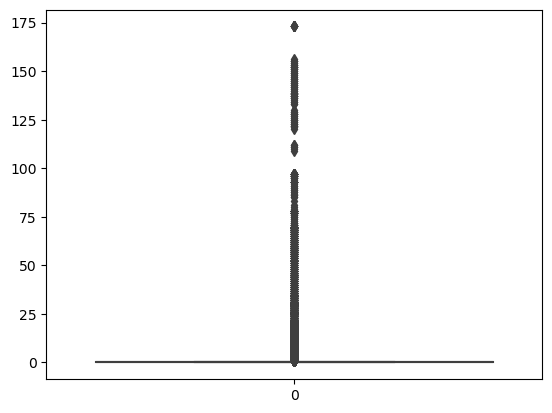

In [24]:
sns.boxplot(df['delay_in_minutes'].values)

In [10]:
late_values = df.query('delay_in_minutes < 0')['delay_in_minutes'].unique()
late_values[::-1].sort()
print(late_values)

[   -1 -1371 -1372 -1373 -1374 -1375 -1408 -1409 -1410 -1411 -1412 -1414
 -1416 -1417 -1418 -1419 -1426 -1427 -1428 -1429 -1430 -1431 -1432 -1433
 -1434 -1435 -1436 -1437 -1438 -1439]


<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference on delays (in minutes) and departure delays</font></h3>
    
<li> Where departure_hour_delayed is NaN, the departure was punctual, therefore this column should be the same as departure_hour
<li> The values with -1 should be considered 0, as they were punctual
<li> Below -1 the values indicates around 24 hours of early departure (1440 minutes), as this is impossible they will be considered a wrong date input and will be added 1440 (24 hours in minutes) for the analysis
</div>

In [23]:
df['departure_hour_delayed'] = np.where(df['departure_hour_delayed'].isna(), df['departure_hour'], df['departure_hour_delayed'])
df['delay_in_minutes'] = df['delay_in_minutes'].replace({-1:0})
df['delay_in_minutes'] = df['delay_in_minutes'] + np.where(df['delay_in_minutes'] < -1, 1440, 0)

## 1.3 NaN

In [12]:
df.isna().sum()

alerts                    2
departure_hour_delayed    4
train_model               4
route                     4
station_id                4
direction                 4
destination               4
plattform                 4
departure_hour            4
date                      4
station_and_id            4
delay_in_minutes          0
city                      4
dtype: int64

In [13]:
df[df['alerts'].isna()]

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes,city
7815,NaN,20:12,RB30(11129),Ahrbrück 19:03-Heimersheim 19:37-Bad...,8000044.0,arr,Ahrbrück,2,20:12,16.06.19,Bonn%238000044,0,Bonn
211238,NaN,14:51,RE 2(4261),Koblenz Hbf 13:04-Boppard Hbf 13:16-...,8000105.0,arr,Koblenz Hbf,20,14:49,20.06.19,Frankfurt%238000105,2,Frankfurt


In [14]:
df[df['plattform'].isna()].sum()

alerts                     Änderung im Fahrtverlauf!@@Grund: V...
departure_hour_delayed                                          0
train_model                                                     0
route                                                           0
station_id                                                    0.0
direction                                                       0
destination                                                     0
plattform                                                       0
departure_hour                                                  0
date                                                            0
station_and_id                                                  0
delay_in_minutes                                                0
city                                                            0
dtype: object

<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference empty values</font></h3>
    
<li> NaN alerts can be safely casted to an empty string as they were punctual or mostly punctual (2 min delay)
<li> The rest of NaN can be dropped, as the whole entries are empty
</div>

In [15]:
df['alerts'] = df['alerts'].fillna('')
df = df.dropna()
df.shape

(222334, 13)

## 1.5 Advanced duplication

In [20]:
df.query('train_model == "ICE372"').groupby(['alerts', 'train_model', 'route', 'station_id', 'direction', 'destination', 'departure_hour', 'date']).count().reset_index()

,alerts,train_model,route,station_id,direction,destination,departure_hour,date,departure_hour_delayed,plattform,station_and_id,delay_in_minutes,city
0,,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,11:08,20.06.19,1,1,1,1,1
1,,ICE372,Interlaken Ost 06:00-Interlaken West...,8011160.0,arr,Interlaken Ost,16:01,20.06.19,1,1,1,1,1
2,Grund: Notarzteinsatz am Gleis,ICE372,Frankfurt(Main)Hbf 11:14-Hanau Hbf 1...,8000105.0,dep,Berlin Ostbahnhof,11:14,20.06.19,4,4,4,4,4
3,Grund: Notarzteinsatz am Gleis,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,11:08,20.06.19,6,6,6,6,6
4,Grund: Technische Störung am Zug,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,11:08,20.06.19,8,8,8,8,8
5,Grund: Technische Störung am Zug@@G...,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,11:08,20.06.19,1,1,1,1,1


<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference same line</font></h3>
    
<li> Above we can see that the delays are updated and get a new entry on the database, as we are only interested in the maximum delay that it happend. We will get the max value of the grouping of the following columns: <b>'alerts', 'train_model', 'route', 'station_id', 'direction', 'destination', 'departure_hour', 'date'<\b>
</div>

In [17]:
df = df.sort_values('delay_in_minutes', ascending=False) \
	.drop_duplicates(subset=['alerts', 'train_model', 'route', 'station_id', 'direction', 'destination', 'departure_hour', 'date'])

df.query('train_model == "ICE372"').groupby(['alerts', 'train_model', 'route', 'station_id', 'direction', 'destination', 'departure_hour', 'date']).count()

departure_hour_delayed  \
alerts                                   train_model route                                    station_id direction destination       departure_hour date                               
                                         ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19                       1   
                                                     Interlaken Ost 06:00-Interlaken West ... 8011160.0  arr       Interlaken Ost    16:01          20.06.19                       1   
 Grund: Notarzteinsatz am Gleis          ICE372      Frankfurt(Main)Hbf 11:14-Hanau Hbf 11... 8000105.0  dep       Berlin Ostbahnhof 11:14          20.06.19                       1   
                                                     Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19                       1   
 Grund: Technische Störung am Zug        ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19                       1   
 Grund: Technische Störung am Zug@@Gl... ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19                       1   

                                                                                                                                                              plattform  \
alerts                                   train_model route                                    station_id direction destination       departure_hour date                  
                                         ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19          1   
                                                     Interlaken Ost 06:00-Interlaken West ... 8011160.0  arr       Interlaken Ost    16:01          20.06.19          1   
 Grund: Notarzteinsatz am Gleis          ICE372      Frankfurt(Main)Hbf 11:14-Hanau Hbf 11... 8000105.0  dep       Berlin Ostbahnhof 11:14          20.06.19          1   
                                                     Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19          1   
 Grund: Technische Störung am Zug        ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19          1   
 Grund: Technische Störung am Zug@@Gl... ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19          1   

                                                                                                                                                              station_and_id  \
alerts                                   train_model route                                    station_id direction destination       departure_hour date                       
                                         ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19               1   
                                                     Interlaken Ost 06:00-Interlaken West ... 8011160.0  arr       Interlaken Ost    16:01          20.06.19               1   
 Grund: Notarzteinsatz am Gleis          ICE372      Frankfurt(Main)Hbf 11:14-Hanau Hbf 11... 8000105.0  dep       Berlin Ostbahnhof 11:14          20.06.19               1   
                                                     Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19               1   
 Grund: Technische Störung am Zug        ICE372      Interlaken Ost 06:00-Interlaken West ... 8000105.0  arr       Interlaken Ost    11:08          20.06.19               1   
 Grund: Technische Störung am Zug@@Gl... ICE372      Interlaken Ost 06:00-Interlaken

In [18]:
df.query('train_model == "NJ 294"')

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes,city
382938,,11:17,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,173,Muenchen
382788,,11:17,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,173,Muenchen
382638,,11:17,NJ 294,Roma Termini 18:58-Chiusi-Chianciano...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,173,Muenchen
383238,Gleiswechsel,11:17,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,9,08:24,20.06.19,Muenchen%238000261,173,Muenchen
383088,Gleiswechsel,11:17,NJ 294,Roma Termini 18:58-Chiusi-Chianciano...,8000261.0,arr,Roma Termini,9,08:24,20.06.19,Muenchen%238000261,173,Muenchen
384138,,08:24,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,0,Muenchen
383988,,08:24,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,0,Muenchen
383538,,08:24,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,0,Muenchen
383838,,08:24,NJ 294,Roma Termini 18:58-Orvieto 19:51-Are...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,0,Muenchen
384515,,08:24,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,0,Muenchen


<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference Gleiswechsel</font></h3>
    
<li> When the departure track is changed there is duplication, we'll remove the entry when there's no delay
</div>

In [19]:
df = df.sort_values('delay_in_minutes', ascending=False).drop_duplicates(subset=['train_model', 'route', 'station_id', 'direction', 'destination', 'departure_hour', 'date'])
df

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes,city
382938,,11:17,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,11,08:24,20.06.19,Muenchen%238000261,173,Muenchen
383238,Gleiswechsel,11:17,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,9,08:24,20.06.19,Muenchen%238000261,173,Muenchen
382787,,11:17,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,173,Muenchen
383088,Gleiswechsel,11:17,NJ 294,Roma Termini 18:58-Chiusi-Chianciano...,8000261.0,arr,Roma Termini,9,08:24,20.06.19,Muenchen%238000261,173,Muenchen
383087,Gleiswechsel,11:17,NJ 40235,Milano Centrale 20:40-Desenzano del ...,8000261.0,arr,Milano Centrale,9,08:24,20.06.19,Muenchen%238000261,173,Muenchen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147066,,12:54,NWBRS1,Bremen-Farge 12:11-Bremen Turnerstra...,8000050.0,arr,Bremen-Farge,5,12:54,20.06.19,Bremen%238000050,0,Bremen
147074,,12:22,NWB RB58(82256),Bremen Hbf 12:22-Bremen Neustadt 12:...,8000050.0,dep,Osnabrück Hbf,2,12:22,20.06.19,Bremen%238000050,0,Bremen
169932,Sonderfahrt,23:42,STR13423,"Gröpelingen, Bremen 23:24-Waller Fri...",8000050.0,arr,"Gröpelingen, Bremen","CHauptbahnhof, Bremen",23:42,20.06.19,Bremen%238000050,0,Bremen
147135,,12:38,NWB RB58(82255),Osnabrück Hbf 10:26-Holdorf(Oldb) 11...,8000050.0,arr,Osnabrück Hbf,2,12:38,20.06.19,Bremen%238000050,0,Bremen


In [20]:
df.query('train_model == "NJ 40235"')

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes,city
382787,,11:17,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,173,Muenchen
383087,Gleiswechsel,11:17,NJ 40235,Milano Centrale 20:40-Desenzano del ...,8000261.0,arr,Milano Centrale,9,08:24,20.06.19,Muenchen%238000261,173,Muenchen
383237,Gleiswechsel,11:17,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,9,08:24,20.06.19,Muenchen%238000261,173,Muenchen
382937,,11:17,NJ 40235,Milano Centrale 20:40-Brescia 21:44-...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,173,Muenchen
382487,,11:17,NJ 40235,Milano Centrale 20:40-Brescia 21:44-...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,173,Muenchen
384591,,08:24,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,0,Muenchen
384668,,08:24,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,0,Muenchen
384895,,08:24,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,0,Muenchen
384745,,08:24,NJ 40235,Milano Centrale 20:40-Desenzano del ...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,0,Muenchen
384514,,08:24,NJ 40235,Milano Centrale 20:40-Milano Lambrat...,8000261.0,arr,Milano Centrale,-,08:24,20.06.19,Muenchen%238000261,0,Muenchen


In [21]:
print(df.query('train_model == "NJ 40235"')['route'].iloc[0])
print(df.query('train_model == "NJ 40235"')['route'].iloc[1])

Milano Centrale 20:40-Milano Lambrate 20:50-Brescia 21:44-Desenzano del Garda/Sirmione 22:02-Peschiera del Garda 22:13-Verona Porta Nuova 22:52Villach Hbf 04:00-Schwarzach-St.Veit 05:20-Salzburg Hbf 06:27-München Hbf 08:24
Milano Centrale 20:40-Desenzano del Garda/Sirmione 22:02-Peschiera del Garda 22:13-Vicenza 23:24-Padova 23:44-Tarvisio Boscoverde 02:45Villach Hbf 04:00-Schwarzach-St.Veit 05:20-Salzburg Hbf 06:27-München Hbf 08:24


<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference Gleiswechsel</font></h3>
    
<li> When there's a change in the route there's a double entry, we'll remove that and keep only the most recent entry'
</div>

In [29]:
df = (df.sort_values(['alerts', 'delay_in_minutes'], ascending=False)
	.sort_index(ascending=False)
	.drop_duplicates(subset=['train_model', 'station_id', 'direction', 'destination', 'departure_hour', 'date']))
df

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes,city
459382,,23:55,S2,Stuttgart Hbf (tief) 23:55-Stuttgart...,8098096.0,dep,Filderstadt,101,23:55,20.06.19,Stuttgart%238098096,0,Stuttgart
459381,,23:55,S1,Stuttgart Hbf (tief) 23:55-Stuttgart...,8098096.0,dep,Kirchheim(Teck),102,23:55,20.06.19,Stuttgart%238098096,0,Stuttgart
459379,,23:48,S6,Stuttgart Hbf (tief) 23:48-Stuttgart...,8098096.0,dep,Weil der Stadt,102,23:48,20.06.19,Stuttgart%238098096,0,Stuttgart
459377,,23:48,RE87(52287),Stuttgart Hbf 23:48-Böblingen 00:08-...,8098096.0,dep,Rottweil,7Stuttgart Hbf,23:48,20.06.19,Stuttgart%238098096,0,Stuttgart
459375,,23:45,S3,Stuttgart Hbf (tief) 23:45-Stuttgart...,8098096.0,dep,Backnang,102,23:45,20.06.19,Stuttgart%238098096,0,Stuttgart
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,,15:44,IC2026,Frankfurt(Main)Hbf 13:44-Frankfurt(M...,8000044.0,arr,Frankfurt(Main)Hbf,2,15:44,16.06.19,Bonn%238000044,0,Bonn
1152,,15:35,IC2011,Berlin Ostbahnhof 08:49-Berlin Hbf 0...,8000044.0,arr,Berlin Ostbahnhof,3,15:35,16.06.19,Bonn%238000044,0,Bonn
1150,,15:26,RB26(25429),Köln Messe/Deutz 14:50-Köln Hbf 14:5...,8000044.0,arr,Köln Messe/Deutz,3,15:26,16.06.19,Bonn%238000044,0,Bonn
1149,,15:21,IC2004,Konstanz 09:07-Radolfzell 09:21-Sing...,8000044.0,arr,Konstanz,2,15:21,16.06.19,Bonn%238000044,0,Bonn


In [30]:
# Random sampling to check for anomalies
df.sort_values('departure_hour').query(f'train_model == "{df["train_model"].sample(1).values[0]}"')

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes,city
202162,,11:03,S6,Frankfurt(Main)Süd 10:53-Frankfurt(M...,8000105.0,arr,Frankfurt(Main)Süd,104Frankfurt Hbf (tief),11:03,20.06.19,Frankfurt%238000105,0,Frankfurt
202558,,11:04,S6,Frankfurt Hbf (tief) 11:04-Frankfurt...,8000105.0,dep,Bad Vilbel,104Frankfurt Hbf (tief),11:04,20.06.19,Frankfurt%238000105,0,Frankfurt
315341,,11:06,S6,Köln-Nippes 11:02-Köln Hansaring 11:...,8000207.0,arr,Köln-Nippes,10 A-B,11:06,20.06.19,Koeln%238000207,0,Koeln
317732,,11:07,S6,Köln Hbf 11:07-Köln Messe/Deutz Gl. ...,8000207.0,dep,Essen Hbf,10 A-B,11:07,20.06.19,Koeln%238000207,0,Koeln
355392,,11:08,S6,Mannheim Hbf 09:44-Osthofen 10:31-Me...,8000240.0,arr,Mannheim Hbf,1a,11:08,20.06.19,Mainz%238000240,0,Mainz
...,...,...,...,...,...,...,...,...,...,...,...,...,...
422786,,23:49,S6,München Hbf (tief) 23:49-München Kar...,8000261.0,dep,München Ost,1München Hbf (tief),23:49,20.06.19,Muenchen%238000261,0,Muenchen
423416,,23:49,S6,Tutzing 23:04-Feldafing 23:08-Possen...,8000261.0,arr,Tutzing,1München Hbf (tief),23:49,20.06.19,Muenchen%238000261,0,Muenchen
237106,,23:53,S6,Bad Vilbel 23:34-Bad Vilbel Süd 23:3...,8000105.0,arr,Bad Vilbel,13,23:53,20.06.19,Frankfurt%238000105,0,Frankfurt
353203,,23:54,S6,Essen Hbf 22:18-Düsseldorf-Rath Mitt...,8000207.0,arr,Essen Hbf,11 B-C,23:54,20.06.19,Koeln%238000207,0,Koeln


In [25]:
df.sort_values('departure_hour').query(f'train_model == "ICE706"')

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes,city
393915,,13:55,ICE706,München Hbf 13:55-Ingolstadt Hbf 14:...,8000261.0,dep,Hamburg-Altona,22,13:55,20.06.19,Muenchen%238000261,0,Muenchen
90500,,18:26,ICE706,München Hbf 13:55-Ingolstadt Hbf 14:...,8089021.0,arr,München Hbf,7Berlin Hbf (tief),18:26,20.06.19,Berlin%238089021,0,Berlin
127796,,18:26,ICE706,München Hbf 13:55-Ingolstadt Hbf 14:...,8011160.0,arr,München Hbf,7Berlin Hbf (tief),18:26,20.06.19,Berlin%238011160,0,Berlin
131441,,18:38,ICE706,Berlin Hbf (tief) 18:38-Berlin-Spand...,8011160.0,dep,Hamburg-Altona,7Berlin Hbf (tief),18:38,20.06.19,Berlin%238011160,0,Berlin
90305,,18:38,ICE706,Berlin Hbf (tief) 18:38-Berlin-Spand...,8089021.0,dep,Hamburg-Altona,7Berlin Hbf (tief),18:38,20.06.19,Berlin%238089021,0,Berlin
270356,,20:23,ICE706,München Hbf 13:55-Ingolstadt Hbf 14:...,8002549.0,arr,München Hbf,6,20:23,20.06.19,Hamburg%238002549,0,Hamburg


In [26]:
print('Stations in Berlin: ', df.query('station_and_id.str.contains("Berlin")')['station_id'].unique())
df.query('station_and_id.str.contains("Berlin")').iloc[2:4]

Stations in Berlin:  [8089021. 8011160.]


,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes,city
133992,Änderung im Fahrtverlauf!@@Grund: T...,20:20,ICE 1002,München Hbf 15:56-Nürnberg Hbf 17:01...,8011160.0,arr,München Hbf,5Berlin Hbf (tief),19:51,20.06.19,Berlin%238011160,29,Berlin
91410,Änderung im Fahrtverlauf!@@Grund: P...,19:09,ICE651,Köln Hbf 14:48-Wuppertal Hbf 15:16-H...,8089021.0,arr,Köln Hbf,5Berlin Hbf (tief),19:05,20.06.19,Berlin%238089021,4,Berlin


In [27]:
df['station_and_id'].unique()

array(['Frankfurt%238000105', 'Mainz%238000240', 'Berlin%238089021',
       'Hamburg%238002549', 'Hannover%238000152', 'Muenchen%238000261',
       'Koeln%238000207', 'Stuttgart%238098096', 'Berlin%238011160',
       'Bremen%238000050', 'Bonn%238000044', 'Koblenz%238000206',
       'Dresden%238010085'], dtype=object)

In [28]:
df.query('station_and_id.str.contains("Berlin")').sort_values(['train_model', 'departure_hour'])

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes,city
102082,,22:45,BUS43470,Berlin Hbf (Europaplatz) 22:45-Pozna...,8089021.0,dep,Warszawa Dworzec Zachodni,-Berlin Hbf (Europaplatz),22:45,20.06.19,Berlin%238089021,0,Berlin
142079,,22:45,BUS43470,Berlin Hbf (Europaplatz) 22:45-Pozna...,8011160.0,dep,Warszawa Dworzec Zachodni,-Berlin Hbf (Europaplatz),22:45,20.06.19,Berlin%238011160,0,Berlin
134692,Grund: Verspätung im Ausland,21:12,EC 170,Praha hl.n. 16:32-Praha-Holesovice 1...,8011160.0,arr,Praha hl.n.,8Berlin Hbf (tief),20:41,20.06.19,Berlin%238011160,31,Berlin
95602,Grund: Verspätung im Ausland,21:12,EC 170,Praha hl.n. 16:32-Praha-Holesovice 1...,8089021.0,arr,Praha hl.n.,8Berlin Hbf (tief),20:41,20.06.19,Berlin%238089021,31,Berlin
89439,Grund: Verspätung im Ausland,18:58,EC 172,Budapest-Nyugati 07:40-Brno dolni na...,8089021.0,arr,Budapest-Nyugati,8Berlin Hbf (tief),18:41,20.06.19,Berlin%238089021,17,Berlin
...,...,...,...,...,...,...,...,...,...,...,...,...,...
143658,,23:47,S7,Berlin Hbf (S-Bahn) 23:47-Berlin Bel...,8011160.0,dep,Potsdam Hbf (S),16Berlin Hbf (S-Bahn),23:47,20.06.19,Berlin%238011160,0,Berlin
103353,,23:58,S7,Potsdam Hbf (S) 23:21-Potsdam-Babels...,8089021.0,arr,Potsdam Hbf (S),15,23:58,20.06.19,Berlin%238089021,0,Berlin
103693,,23:58,S7,Berlin Hbf (S-Bahn) 23:58-Berlin Fri...,8089021.0,dep,Ahrensfelde (S),15,23:58,20.06.19,Berlin%238089021,0,Berlin
143385,,23:58,S7,Potsdam Hbf (S) 23:21-Berlin Westkre...,8011160.0,arr,Potsdam Hbf (S),15Berlin Hbf (S-Bahn),23:58,20.06.19,Berlin%238011160,0,Berlin


<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference Stations</font></h3>
    
<li> Berlin is the only city with 2 station id's and some travels are allocated to both stations, these duplicated entries will be removed
</div>

In [29]:
mask_duplicated_station = df.duplicated(subset=['alerts', 'departure_hour_delayed', 'train_model', 'route', 'direction', 'destination', 'plattform', 'departure_hour', 'date', 'delay_in_minutes'])
df.loc[mask_duplicated_station, 'station_and_id'].unique()
print('Duplicated station entries: ', mask_duplicated_station.sum())
df = df[~mask_duplicated_station]
df

Duplicated station entries:  111


,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes,city
228723,Änderung im Fahrtverlauf!@@Grund: Z...,20:45,RE50(4531),Fulda 19:04-Bad Soden-Salmünster 19:...,8000105.0,arr,Fulda,5,20:28,20.06.19,Frankfurt%238000105,17,Frankfurt
362536,Änderung im Fahrtverlauf!@@Grund: Z...,15:25,EC 8,Zürich HB 11:00-Basel SBB 12:20-Base...,8000240.0,arr,Zürich HB,3a/b,15:18,20.06.19,Mainz%238000240,7,Mainz
85082,Änderung im Fahrtverlauf!@@Grund: Z...,17:23,RE 3(3333),Eberswalde Hbf 16:42-Melchow16:48-Bi...,8089021.0,arr,Eberswalde Hbf,4Berlin Hbf (tief),17:20,20.06.19,Berlin%238089021,3,Berlin
270480,Änderung im Fahrtverlauf!@@Grund: V...,20:56,ICE 72,Chur 10:39-Landquart 10:49-Sargans 1...,8002549.0,arr,Chur,13,19:54,20.06.19,Hamburg%238002549,62,Hamburg
300018,Änderung im Fahrtverlauf!@@Grund: V...,19:32,ICE 72,Chur 10:39-Landquart 10:49-Sargans 1...,8000152.0,arr,Chur,8,18:34,20.06.19,Hannover%238000152,58,Hannover
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146252,,12:03,RE 8(4417),Bremerhaven-Lehe 11:23-Bremerhaven H...,8000050.0,arr,Bremerhaven-Lehe,7,12:03,20.06.19,Bremen%238000050,0,Bremen
146254,,12:05,IC2039,Norddeich Mole 09:36-Norddeich 09:39...,8000050.0,arr,Norddeich Mole,1,12:05,20.06.19,Bremen%238000050,0,Bremen
157327,,17:15,IC2243,Bremen Hbf 17:15-Hannover Hbf 18:13,8000050.0,dep,Hannover Hbf,6,17:15,20.06.19,Bremen%238000050,0,Bremen
124578,,17:24,RE 2(63983),Cottbus Hbf 16:01-Vetschau 16:12-Lüb...,8011160.0,arr,Cottbus Hbf,14,17:24,20.06.19,Berlin%238011160,0,Berlin


## 1.6 Line Types

In [30]:
df['train_model'].sort_values().sample(20).values

array(['ALX79858', 'IC2295', 'IC2229', 'S1', 'S5', 'S8', 'S5', 'S2',
       'RE 59073', 'RB68(15318)', 'S5', 'RE 3(74038)', 'RE 2(4261)',
       'ICE801', 'S8', 'S1', 'S 31', 'RB68(15330)', 'S5', 'RB31(29277)'],
      dtype=object)

<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference Train types</font></h3>
    
<li> Lines are defined by the [letters and spaces] in the beginning, followed by space and/or numbers, a new columns will be created with the identification in the beginning
</div>

In [31]:
df['line_type'] = df['train_model'].str.extract(pat='(^[^\d(]*)')
df['line_type'] = df['line_type'].str.strip()
df

C:\Users\Kriggs\AppData\Local\Temp\ipykernel_1404\3003274993.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['line_type'] = df['train_model'].str.extract(pat='(^[^\d(]*)')
C:\Users\Kriggs\AppData\Local\Temp\ipykernel_1404\3003274993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['line_type'] = df['line_type'].str.strip()


,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes,city,line_type
228723,Änderung im Fahrtverlauf!@@Grund: Z...,20:45,RE50(4531),Fulda 19:04-Bad Soden-Salmünster 19:...,8000105.0,arr,Fulda,5,20:28,20.06.19,Frankfurt%238000105,17,Frankfurt,RE
362536,Änderung im Fahrtverlauf!@@Grund: Z...,15:25,EC 8,Zürich HB 11:00-Basel SBB 12:20-Base...,8000240.0,arr,Zürich HB,3a/b,15:18,20.06.19,Mainz%238000240,7,Mainz,EC
85082,Änderung im Fahrtverlauf!@@Grund: Z...,17:23,RE 3(3333),Eberswalde Hbf 16:42-Melchow16:48-Bi...,8089021.0,arr,Eberswalde Hbf,4Berlin Hbf (tief),17:20,20.06.19,Berlin%238089021,3,Berlin,RE
270480,Änderung im Fahrtverlauf!@@Grund: V...,20:56,ICE 72,Chur 10:39-Landquart 10:49-Sargans 1...,8002549.0,arr,Chur,13,19:54,20.06.19,Hamburg%238002549,62,Hamburg,ICE
300018,Änderung im Fahrtverlauf!@@Grund: V...,19:32,ICE 72,Chur 10:39-Landquart 10:49-Sargans 1...,8000152.0,arr,Chur,8,18:34,20.06.19,Hannover%238000152,58,Hannover,ICE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146252,,12:03,RE 8(4417),Bremerhaven-Lehe 11:23-Bremerhaven H...,8000050.0,arr,Bremerhaven-Lehe,7,12:03,20.06.19,Bremen%238000050,0,Bremen,RE
146254,,12:05,IC2039,Norddeich Mole 09:36-Norddeich 09:39...,8000050.0,arr,Norddeich Mole,1,12:05,20.06.19,Bremen%238000050,0,Bremen,IC
157327,,17:15,IC2243,Bremen Hbf 17:15-Hannover Hbf 18:13,8000050.0,dep,Hannover Hbf,6,17:15,20.06.19,Bremen%238000050,0,Bremen,IC
124578,,17:24,RE 2(63983),Cottbus Hbf 16:01-Vetschau 16:12-Lüb...,8011160.0,arr,Cottbus Hbf,14,17:24,20.06.19,Berlin%238011160,0,Berlin,RE


## 1.7 Alerts

In [32]:
df['alerts'].unique()[:10]

array([' Änderung im Fahrtverlauf!@@Grund: Zusätzlicher Halt zum Ein- /Ausstieg für Reisende',
       ' Änderung im Fahrtverlauf!@@Grund: Verzögerungen im Betriebsablauf@@Gleiswechsel',
       ' Änderung im Fahrtverlauf!@@Grund: Verzögerungen im Betriebsablauf',
       ' Änderung im Fahrtverlauf!@@Grund: Verspätung eines vorausfahrenden Zuges',
       ' Änderung im Fahrtverlauf!@@Grund: Umleitung des Zuges',
       ' Änderung im Fahrtverlauf!@@Grund: Technische Störung an einem anderen Zug@@Gleiswechsel',
       ' Änderung im Fahrtverlauf!@@Grund: Technische Störung an einem anderen Zug',
       ' Änderung im Fahrtverlauf!@@Grund: Technische Störung an der Strecke@@Gleiswechsel',
       ' Änderung im Fahrtverlauf!@@Grund: Technische Störung am Zug@@Gleiswechsel',
       ' Änderung im Fahrtverlauf!@@Grund: Technische Störung am Zug'],
      dtype=object)

In [33]:
alerts = df.query('alerts != " "')['alerts'].str.replace('@@', ' @@ ')

reasons_alert = alerts.str.extract('Grund: ([^@]+)').dropna()[0].unique()
reasons_alert = np.vectorize(lambda s: s.strip())(reasons_alert)
reasons_alert = np.unique(reasons_alert)

reasons_alert = np.concatenate((reasons_alert,
           [
    	'Gleiswechsel',
        'Fahrt fällt aus',
        'Ersatzfahrt',
        'Sonderfahrt',
        'Fährt heute erst ab',
        'Änderung im Fahrtverlauf!'
	]),
    axis=0
)

mask_categorized_alerts = alerts.str.contains(f'{"|".join(reasons_alert)}')

alerts_left = alerts[~mask_categorized_alerts]
print(len(alerts_left))
alerts_left.iloc[0:50]

0


Series([], Name: alerts, dtype: object)

In [34]:
print('Total number of alert types: ', len(reasons_alert))
print(reasons_alert)

Total number of alert types:  44
['Außerplanmäßige Geschwindigkeitsbeschränkung' 'Bauarbeiten'
 'Behobene technische Störung am Zug' 'Betätigen der Notbremse'
 'Feuerwehreinsatz an der Strecke' 'Gegenstände im Gleis'
 'Notarzteinsatz am Gleis' 'Oberleitungsstörung' 'Personen im Gleis'
 'Polizeiliche Ermittlung' 'Signalstörung' 'Stellwerksstörung /-ausfall'
 'Streckensperrung' 'Störung an einem Bahnübergang'
 'Technische Störung am Bahnhof' 'Technische Störung am Zug'
 'Technische Störung an der Strecke'
 'Technische Störung an einem anderen Zug'
 'Technische Untersuchung am Zug' 'Türstörung'
 'Umgestürzter Baum im Gleis' 'Umleitung des Zuges'
 'Verspätete Bereitstellung des Zuges' 'Verspätung aus vorheriger Fahrt'
 'Verspätung eines vorausfahrenden Zuges' 'Verspätung im Ausland'
 'Verzögerung beim Ein-/Ausstieg' 'Verzögerungen im Betriebsablauf'
 'Warten auf Fahrgäste aus einem Bus'
 'Warten auf Fahrgäste aus einem anderen Zug'
 'Warten auf einen entgegenkommenden Zug' 'Warten auf frei

In [35]:
separated_alerts = alerts.str.extractall(f'({"|".join(reasons_alert)})').unstack()[0].rename(columns={0:'delay_reason_1',1:'delay_reason_2',2:'delay_reason_3'})
separated_alerts

match,delay_reason_1,delay_reason_2,delay_reason_3
1581,Personen im Gleis,NaN,NaN
1658,Personen im Gleis,NaN,NaN
1696,Personen im Gleis,NaN,NaN
3071,Bauarbeiten,NaN,NaN
3184,Bauarbeiten,NaN,NaN
...,...,...,...
457010,Verspätung eines vorausfahrenden Zuges,NaN,NaN
457011,Verspätung eines vorausfahrenden Zuges,Gleiswechsel,NaN
457790,Gleiswechsel,NaN,NaN
457822,Verzögerung beim Ein-/Ausstieg,NaN,NaN


In [36]:
alerts_long = separated_alerts.reset_index().melt(id_vars='index')
alerts_long

,index,match,value
0,1581,delay_reason_1,Personen im Gleis
1,1658,delay_reason_1,Personen im Gleis
2,1696,delay_reason_1,Personen im Gleis
3,3071,delay_reason_1,Bauarbeiten
4,3184,delay_reason_1,Bauarbeiten
...,...,...,...
5518,457010,delay_reason_3,NaN
5519,457011,delay_reason_3,NaN
5520,457790,delay_reason_3,NaN
5521,457822,delay_reason_3,NaN


<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference Alerts</font></h3>
    
<li> There are 44 different alert types
<li> Some delays have up to 3 different alerts
<li> These alerts will be joined in the main data
</div>

In [37]:
df = pd.merge(left=df, right=separated_alerts, left_index=True, right_index=True, how='left')

## Anomalies check

In [38]:
df.sort_values('delay_in_minutes', ascending=False)

,alerts,departure_hour_delayed,train_model,route,station_id,direction,destination,plattform,departure_hour,date,station_and_id,delay_in_minutes,city,line_type,delay_reason_1,delay_reason_2,delay_reason_3
383087,Gleiswechsel,11:17,NJ 40235,Milano Centrale 20:40-Desenzano del ...,8000261.0,arr,Milano Centrale,9,08:24,20.06.19,Muenchen%238000261,173,Muenchen,NJ,Gleiswechsel,NaN,NaN
383238,Gleiswechsel,11:17,NJ 294,Roma Termini 18:58-Orvieto 19:51-Chi...,8000261.0,arr,Roma Termini,9,08:24,20.06.19,Muenchen%238000261,173,Muenchen,NJ,Gleiswechsel,NaN,NaN
203008,Grund: Notarzteinsatz am Gleis,13:44,ICE372,Interlaken Ost 06:00-Interlaken West...,8000105.0,arr,Interlaken Ost,9,11:08,20.06.19,Frankfurt%238000105,156,Frankfurt,ICE,Notarzteinsatz am Gleis,NaN,NaN
388464,Änderung im Fahrtverlauf!@@Grund: T...,12:30,ICE 1701,Berlin Hbf (tief) 05:34-Berlin Südkr...,8000261.0,arr,Berlin Hbf (tief),18,09:55,20.06.19,Muenchen%238000261,155,Muenchen,ICE,Änderung im Fahrtverlauf!,Technische Störung an der Strecke,Gleiswechsel
203668,Grund: Notarzteinsatz am Gleis,13:49,ICE372,Frankfurt(Main)Hbf 11:14-Hanau Hbf 1...,8000105.0,dep,Berlin Ostbahnhof,9,11:14,20.06.19,Frankfurt%238000105,155,Frankfurt,ICE,Notarzteinsatz am Gleis,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401017,,16:21,S4,München Hbf (tief) 16:21-München Hac...,8000261.0,dep,Geltendorf,2München Hbf (tief),16:21,20.06.19,Muenchen%238000261,0,Muenchen,S,NaN,NaN,NaN
401018,,16:23,RE4078,München Hbf 16:23-München-Moosach 16...,8000261.0,dep,Passau Hbf,25,16:23,20.06.19,Muenchen%238000261,0,Muenchen,RE,NaN,NaN,NaN
401027,,16:30,S2,München Hbf (tief) 16:30-München Hac...,8000261.0,dep,Petershausen(Obb),2München Hbf (tief),16:30,20.06.19,Muenchen%238000261,0,Muenchen,S,NaN,NaN,NaN
401009,,16:12,S6,München Hbf (tief) 16:12-München Hac...,8000261.0,dep,Tutzing,2München Hbf (tief),16:12,20.06.19,Muenchen%238000261,0,Muenchen,S,NaN,NaN,NaN


In [51]:
print(df.sort_values('delay_in_minutes').iloc[-2]['route'])
print(df.sort_values('delay_in_minutes').iloc[-1]['route'])

Milano Centrale 20:40-Desenzano del Garda/Sirmione 22:02-Peschiera del Garda 22:13-Vicenza 23:24-Padova 23:44-Tarvisio Boscoverde 02:45Villach Hbf 04:00-Schwarzach-St.Veit 05:20-Salzburg Hbf 06:27-München Hbf 08:24
Roma Termini 18:58-Orvieto 19:51-Chiusi-Chianciano Terme 20:17-Arezzo 20:52-Firenze S.M.N. 21:55-Bologna Centrale 22:57Schwarzach-St.Veit 05:20-Salzburg Hbf 06:27-Rosenheim 07:36-München Hbf 08:24


<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000">

<h3 align="left"><font color='#125899'>📍 Inference for the biggest delay</font></h3>
    
<li> The two entries with 173 minutes have a different route and train model, but otherwise same platform, destination and departure hour, indicating that one of this trains got delayed and changed to a platform that another train would use, a further inquiry would be needed to clear which train was in reality delayed
</div>

# Save cleaned data for analysis

In [39]:
correct_dtypes = {
	'station_id': 'int32',
	'direction': 'category',
	'delay_in_minutes': 'int16'
}

df = df.astype(correct_dtypes)

output_dir = 'output_files\\'

df.reset_index(drop=True).astype('str').to_feather(output_dir + 'cleaned_data.feather')
df.to_csv(output_dir + 'cleaned_data.csv')